In [460]:
import pandas as pd 
import numpy as np
import torch
from IMUNet import *
from abc import ABC, abstractmethod
import seaborn as sns
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import tqdm

In [187]:
datasets_path = '/home/fabian/Documents/Arbeit/olive/IMUNet/Datasets/' 
file_path = datasets_path + 'olive/lio_interpolated.csv'
dataframe = pd.read_csv(file_path)

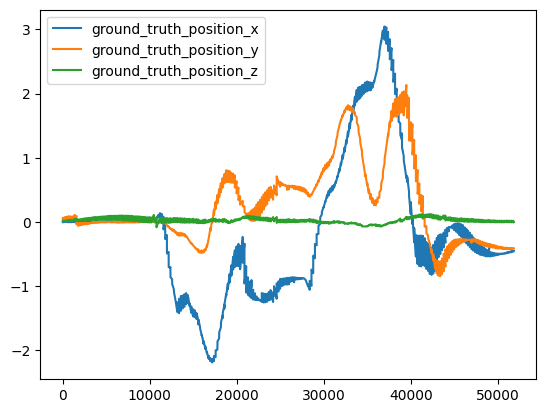

In [256]:
test_dataframe = dataframe[['imu_1_angular_velocity_x', 'imu_1_angular_velocity_y', 'imu_1_angular_velocity_z', 'imu_1_linear_acceleration_x', 'imu_1_linear_acceleration_y', 'imu_1_linear_acceleration_z', 'position_x', 'position_y', 'position_z']]
test_dataframe
# dataframe
test_x = test_dataframe["position_x"]
test_y = test_dataframe["position_y"]
test_z = test_dataframe["position_z"]
plt.plot(np.arange(0, len(test_x)), test_x, label="ground_truth_position_x")
plt.plot(np.arange(0, len(test_y)), test_y, label="ground_truth_position_y")
plt.plot(np.arange(0, len(test_z)), test_z, label="ground_truth_position_z")
plt.legend()

In [351]:
import os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset

class CustomIMUDataset(Dataset):
    def __init__(self, csv_file, sequence_length=200, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with data.
            sequence_length (int): Length of the sequence window.
            transform (callable, optional): Optional transform to be applied on the features.
            target_transform (callable, optional): Optional transform to be applied on the targets.
        """
        self.data = pd.read_csv(csv_file)
        self.sequence_length = sequence_length
        self.transform = transform
        self.target_transform = target_transform

        # Preprocess the data to extract features and targets
        self.features, self.targets = self.preprocess_data()

    def preprocess_data(self):
        # Extract features and targets from the dataframe

        # For example, let's use imu_1 data as features
        features = self.data[[
            'imu_1_angular_velocity_x',
            'imu_1_angular_velocity_y',
            'imu_1_angular_velocity_z',
            'imu_1_linear_acceleration_x',
            'imu_1_linear_acceleration_y',
            'imu_1_linear_acceleration_z'
        ]].values

        # Extract targets, for example positions
        targets = self.data[[
            'position_x',
            'position_y'
            # 'position_z'
        ]].values

        # Convert data to float32
        features = features.astype('float32')
        targets = targets.astype('float32')
        print(f"features shape {features.shape}")
        print(f"targets shape {targets.shape}")

        return features, targets

    def __len__(self):
        # Number of sequences that can be formed from the data
        return len(self.features) - self.sequence_length + 1

    def __getitem__(self, idx):
        # Get a sequence of features and the corresponding target
        features_seq = self.features[idx : idx + self.sequence_length]
        target = self.targets[idx + self.sequence_length - 1]
        # i think target should just be one value for each output instad of sequence length

        # if self.transform:
        #     features_seq = self.transform(features_seq)
        # if self.target_transform:
        #     target = self.target_transform(target)

        # # Transpose features to match expected input shape: [num_features, sequence_length]
        # features_seq = features_seq.T  # Shape: [num_features, sequence_length]

        return features_seq, target

In [518]:
dataset = CustomIMUDataset(csv_file=file_path)
dataset.__getitem__(0)[0].shape


features shape (51818, 6)
targets shape (51818, 2)


(200, 6)

In [557]:
# def train(batchsize=32, lr= 0.001):
lr = 0.1
# Loading data
dataset_size = len(dataset)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batchsize = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# val_dataset, val_loader = None, None

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

network = IMUNet(num_classes= 2, input_size= (6, 200) ,sampling_rate= 200, num_T = 32 , num_S = 64 , hidden = 64, dropout_rate = 0.5).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True, eps=1e-12)
# torch.autograd.set_detect_anomaly(True)
start_epoch = 0
# if args.continue_from is not None and osp.exists(args.continue_from):
#     checkpoints = torch.load(args.continue_from)
#     start_epoch = checkpoints.get('epoch', 0)
#     network.load_state_dict(checkpoints.get('model_state_dict'))
#     optimizer.load_state_dict(checkpoints.get('optimizer_state_dict'))

# if args.out_dir is not None and osp.exists(osp.join(args.out_dir, 'logs')):
#     summary_writer = SummaryWriter(osp.join(args.out_dir, 'logs'))
#     # summary_writer.add_text('info', 'total_param: {}'.format(total_params))

step = 0
best_val_loss = np.inf

print(f'Start from epoch {start_epoch}')
total_epoch = start_epoch
train_losses_all, val_losses_all = [], []

# Get the initial loss.

Start from epoch 0


In [558]:

init_train_targ, init_train_pred = run_test(network, train_loader, device, eval_mode=False)

init_train_loss = np.mean((init_train_targ - init_train_pred) ** 2, axis=0)
train_losses_all.append(np.mean(init_train_loss))
print('-------------------------')
print('Init: average loss: {}/{:.6f}'.format(init_train_loss, train_losses_all[-1]))

 13%|█▎        | 163/1291 [00:07<00:53, 21.28it/s]


KeyboardInterrupt: 

In [ ]:

# if summary_writer is not None:
#     add_summary(summary_writer, init_train_loss, 0, 'train')

# if val_loader is not None:
#     init_val_targ, init_val_pred = run_test(network, val_loader, device)
#     init_val_loss = np.mean((init_val_targ - init_val_pred) ** 2, axis=0)
#     val_losses_all.append(np.mean(init_val_loss))
#     print('Validation loss: {}/{:.6f}'.format(init_val_loss, val_losses_all[-1]))
#     if summary_writer is not None:
#         add_summary(summary_writer, init_val_loss, 0, 'val')


In [567]:
epochs = 1
try:
    for epoch in range(start_epoch, epochs):
        start_t = time.time()
        network.train()
        train_outs, train_targets = [], []
        for batch_id, (feat_batch, targ_batch) in enumerate(tqdm.tqdm(train_loader)):
            feat_batch, targ_batch = feat_batch.to(device), targ_batch.to(device)
            feat_batch = feat_batch.permute(0, 2, 1).contiguous()
            optimizer.zero_grad()
            pred = network(feat_batch)
            train_outs.append(pred.cpu().detach().numpy())
            train_targets.append(targ_batch.cpu().detach().numpy())
            loss = criterion(pred, targ_batch)
            loss = torch.mean(loss)
            print(loss)
            loss.backward()
            optimizer.step()
            step += 1
        train_outs = np.concatenate(train_outs, axis=0)
        train_targets = np.concatenate(train_targets, axis=0)
        train_losses = np.average((train_outs - train_targets) ** 2, axis=0)

        end_t = time.time()
        print('-------------------------')
        print('Epoch {}, time usage: {:.3f}s, average loss: {}/{:.6f}'.format(
            epoch, end_t - start_t, train_losses, np.average(train_losses)))
        train_losses_all.append(np.average(train_losses))

        # if summary_writer is not None:
        #     add_summary(summary_writer, train_losses, epoch + 1, 'train')
        #     summary_writer.add_scalar('optimizer/lr', optimizer.param_groups[0]['lr'], epoch)

        # if val_loader is not None:
        #     network.eval()
        #     val_outs, val_targets = run_test(network, val_loader, device)
        #     val_losses = np.average((val_outs - val_targets) ** 2, axis=0)
        #     avg_loss = np.average(val_losses)
        #     print('Validation loss: {}/{:.6f}'.format(val_losses, avg_loss))
        #     scheduler.step(avg_loss)
        #     if summary_writer is not None:
        #         add_summary(summary_writer, val_losses, epoch + 1, 'val')
        #     val_losses_all.append(avg_loss)
        #     if avg_loss < best_val_loss:
        #         best_val_loss = avg_loss
        #         if args.out_dir and osp.isdir(args.out_dir):
        #             model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_best.pt')
        #             torch.save({'model_state_dict': network.state_dict(),
        #                         'epoch': epoch,
        #                         'optimizer_state_dict': optimizer.state_dict()}, model_path)
        #             print('Model saved to ', model_path)

        total_epoch = epoch

except KeyboardInterrupt:
    print('-' * 60)
    print('Early terminate')

print('Training complete')
if args.out_dir:
    model_path = osp.join(args.out_dir, 'checkpoints', 'checkpoint_latest.pt')
    torch.save({'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': total_epoch}, model_path)
    print('Checkpoint saved to ', model_path)

    # return train_losses_all, val_losses_all

  0%|          | 0/1291 [00:00<?, ?it/s]

  0%|          | 1/1291 [00:00<05:53,  3.64it/s]

tensor(0.7650, grad_fn=<MeanBackward0>)
tensor(0.4158, grad_fn=<MeanBackward0>)


  0%|          | 3/1291 [00:00<04:06,  5.22it/s]

tensor(1.5204, grad_fn=<MeanBackward0>)
tensor(0.5947, grad_fn=<MeanBackward0>)


  0%|          | 5/1291 [00:00<03:56,  5.44it/s]

tensor(0.6283, grad_fn=<MeanBackward0>)
tensor(1.1637, grad_fn=<MeanBackward0>)


  1%|          | 7/1291 [00:01<03:55,  5.46it/s]

tensor(0.2119, grad_fn=<MeanBackward0>)
tensor(0.6201, grad_fn=<MeanBackward0>)


  1%|          | 9/1291 [00:01<03:45,  5.69it/s]

tensor(0.9481, grad_fn=<MeanBackward0>)
tensor(0.1893, grad_fn=<MeanBackward0>)


  1%|          | 11/1291 [00:02<04:10,  5.10it/s]

tensor(0.7200, grad_fn=<MeanBackward0>)


  1%|          | 12/1291 [00:02<04:02,  5.27it/s]

tensor(0.3445, grad_fn=<MeanBackward0>)
tensor(0.2953, grad_fn=<MeanBackward0>)


  1%|          | 14/1291 [00:02<03:45,  5.66it/s]

tensor(0.9422, grad_fn=<MeanBackward0>)
tensor(0.2579, grad_fn=<MeanBackward0>)


  1%|          | 15/1291 [00:02<04:04,  5.22it/s]

tensor(0.8443, grad_fn=<MeanBackward0>)
------------------------------------------------------------
Early terminate
Training complete


NameError: name 'args' is not defined

In [537]:
def run_test(network, data_loader, device, eval_mode=True):
    targets_all = []
    preds_all = []
    if eval_mode:
        network.eval()
    for idx, (feat_batch, targ_batch) in enumerate(tqdm.tqdm(data_loader)):
        feat = feat_batch.permute(0, 2, 1).contiguous()
        pred = network(feat).cpu().detach().numpy()
        targets_all.append(targ_batch.detach().numpy())
        preds_all.append(pred.squeeze())
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)
    return targets_all, preds_all

In [538]:
device = "cpu"
network = IMUNet(num_classes= 2, input_size= (6, 200) ,sampling_rate= 200, num_T = 32 , num_S = 64 , hidden = 64, dropout_rate = 0.5).to(device)
# print(network)
targets_all, preds_all = run_test(network, test_loader, "cpu")

100%|██████████| 323/323 [00:13<00:00, 23.27it/s]


In [540]:
targets_all.shape, preds_all.shape

((10323, 2), (10323, 2))

In [529]:
    targets_all = []
    preds_all = []
    network.eval()
    for idx, (feat_batch, targ_batch) in enumerate(tqdm.tqdm(test_loader)):
            feat = feat_batch.permute(0, 2, 1).contiguous()
            pred = network(feat).cpu().detach().numpy()
            targets_all.append(targ_batch.detach().numpy())
            preds_all.append(pred.squeeze())
    targets_all = np.concatenate(targets_all, axis=0)
    preds_all = np.concatenate(preds_all, axis=0)

    

100%|██████████| 323/323 [00:14<00:00, 22.67it/s]


In [534]:
targets_all.shape, preds_all.shape
np.mean((targets_all - preds_all) ** 2)

np.float32(1.1329665)